In [1]:
# theta-only-test.ipynb

# in this notebook we look at modelling the waveform at a single value
# of time to speed up testing of fitting the other physical parameters
#
# i think i can do this because RFF seems to work so well
# that once the 'theta' parameters can be fit well all you
# need to do is add O(1000) times more data for the times.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [3]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

2022-07-09 16:38:32.088948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 16:38:32.088989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import wispy.callbacks

In [5]:
from model_utils import PoisonPillCallback

In [6]:
import pandas as pd

In [7]:
import tensorflow as tf

In [8]:
import pycbc.pnutils

In [9]:
import lalsimulation as lalsim

In [10]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [19]:
def gen_waveform_set(train_test_val, n_samples, t_index, nproc=1, mass_ratio_low=1, mass_ratio_high=8, return_data='hp_hc'):
    assert train_test_val in ['train', 'val']
    
    # approximant="IMRPhenomXHM"
    # approximant="IMRPhenomXPHM"
    # approximant="SEOBNRv4PHM"
    # approximant="IMRPhenomXAS"
    approximant="SEOBNRv4_opt"
    # approximant="SEOBNRv4P"
    # approximant="IMRPhenomXP"
    # approximant="IMRPhenomD"
    # approximant="IMRPhenomHM"

    # uniform spacing throughout
    t1 = -2000
    # t1 = -500
    # t1 = -200
    # t1 = -50
    
    # t1 = -50
    t2 = 70
    # t1 = -10
    # t2 = 20
    dt = 0.25
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    # t_training_idxs = None
    # t_validation_idxs = None
    if train_test_val == "train":
        t_idxs_sample = t_idxs[::2]
    elif train_test_val == "val":
        # t_idxs_sample = t_idxs[1::2]
        t_idxs_sample = t_idxs[::2]

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    # out = sample.draw_mass_ratio_inc_coa_phase_samples(n_samples, mass_ratio_low, mass_ratio_high)
    # out = sample.draw_inc_coa_phase_samples(n_samples, mass_ratio=1)
    out = sample.draw_9d_samples(n_samples, mass_ratio_low=1, mass_ratio_high=2)
    # out = sample.draw_mass_ratio_samples(n_samples, mass_ratio_low, mass_ratio_high)
    mass_ratios = out[0]
    # spin1xs = out[1]
    # spin1ys = out[2]
    spin1xs = np.zeros_like(out[1])
    spin1ys = np.zeros_like(out[2])
    # spin1zs = out[3]
    spin1zs = np.zeros_like(out[3])
    # spin2xs = out[4]
    # spin2ys = out[5]
    spin2xs = np.zeros_like(out[4])
    spin2ys = np.zeros_like(out[5])
    # spin2zs = out[6]
    spin2zs = np.zeros_like(out[6])
    coa_phases = out[7]
    # coa_phases = np.zeros_like(out[7])
    inclinations = out[8]
    # inclinations = np.zeros_like(out[8]) + np.pi/2.1
    # inclinations = np.zeros_like(out[8]) + np.pi/1.9
    # inclinations = np.zeros_like(out[8]) + (5 * 180/np.pi)

    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        mass_ratios,
        spin1xs,
        spin1ys,
        spin1zs,
        spin2xs,
        spin2ys,
        spin2zs,
        coa_phases,
        inclinations,
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
        return_data=return_data,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    return times[t_index][:,np.newaxis], thetas, hps[:,t_index][:,np.newaxis], hcs[:,t_index][:,np.newaxis]

In [20]:
parameter_names = ['mass_ratio', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'coa_phase', 'inclination']

In [21]:
# n_samples_train=50000
# n_samples_train=8000
n_samples_train=100_000
n_samples_val=100

# return_data='amp_phi'
return_data='hp_hc'

t_index = 100

In [22]:
train_times, train_thetas, train_hps, train_hcs = gen_waveform_set(t_index=t_index, train_test_val='train', n_samples=n_samples_train, nproc=40, return_data=return_data)
# train_times, train_thetas, train_hcs, train_hps = gen_waveform_set(train_test_val='train', n_samples=n_samples_train, nproc=8)

The time cost: 0:09:25.224979


In [23]:
[ii.shape for ii in [train_times, train_thetas, train_hps, train_hcs]]

[(1, 1), (100000, 9), (100000, 1), (100000, 1)]

In [24]:
# train_thetas[:,[0,7,8]]

In [25]:
val_times, val_thetas, val_hps, val_hcs = gen_waveform_set(t_index=t_index, train_test_val='val', n_samples=n_samples_val, nproc=4, return_data=return_data)
# val_times, val_thetas, val_hcs, val_hps = gen_waveform_set(train_test_val='val', n_samples=n_samples_val, nproc=4)

The time cost: 0:00:02.325303


In [26]:
[ii.shape for ii in [val_times, val_thetas, val_hps, val_hcs]]

[(1, 1), (100, 9), (100, 1), (100, 1)]

In [27]:
train_thetas

array([[1.39322792, 0.        , 0.        , ..., 0.        , 1.08840438,
        2.12040474],
       [1.20675213, 0.        , 0.        , ..., 0.        , 1.35932789,
        2.58510566],
       [1.116438  , 0.        , 0.        , ..., 0.        , 3.39411698,
        1.15234881],
       ...,
       [1.53381147, 0.        , 0.        , ..., 0.        , 5.37862447,
        1.94016436],
       [1.69058035, 0.        , 0.        , ..., 0.        , 4.94159617,
        2.28977093],
       [1.50321304, 0.        , 0.        , ..., 0.        , 1.05400234,
        2.19413005]])

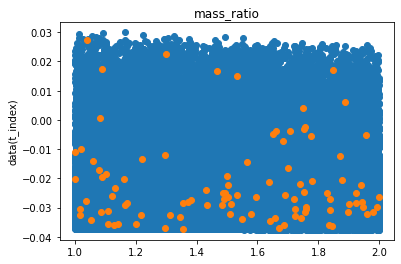

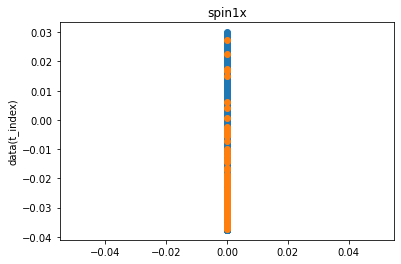

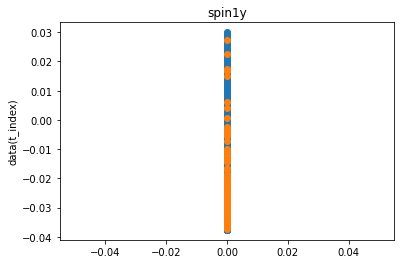

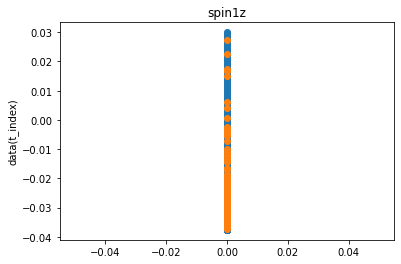

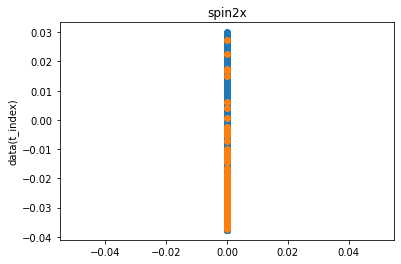

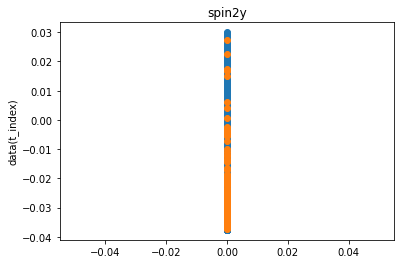

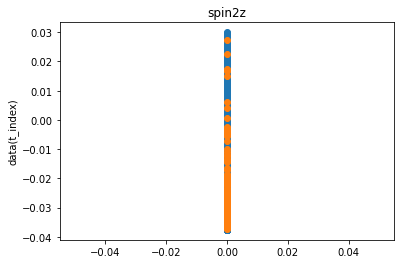

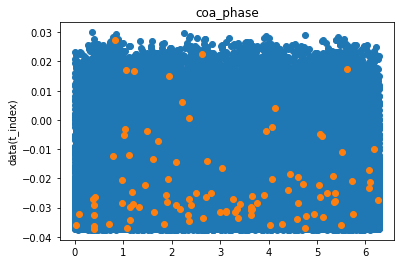

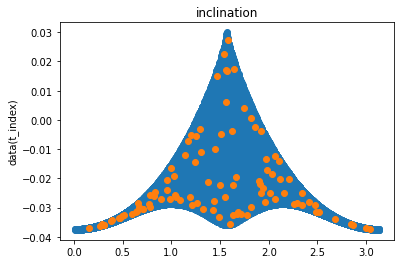

In [28]:
for i in range(train_thetas.shape[1]):
    plt.figure()
    plt.plot(train_thetas[:,i], train_hps, 'o')
    plt.plot(val_thetas[:,i], val_hps, 'o')
    plt.title(parameter_names[i])
    plt.ylabel('data(t_index)')

# setup and fit model

In [50]:
def create_model(model_type, theta_input_shape, theta_b_scale, fan_in=128, n_layers=3, units=256, activation='relu'):
    if model_type == 'rff':
        theta_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale)
        theta_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x_theta = tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializer, bias_initializer=theta_bias_initializer, trainable=False)(theta_input)
        x = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_theta)
    elif model_type == 'rff-all':
        theta_kernel_initializers = [tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale) for i in range(theta_input_shape)]
        theta_bias_initializers = [tf.keras.initializers.RandomUniform(minval=-1., maxval=1.) for i in range(theta_input_shape)]
        theta_inputs = [tf.keras.Input(shape=(1,), name=f'theta_input_{i}') for i in range(theta_input_shape)]
        x_thetas = []
        xs = []
        for i, theta_input in enumerate(theta_inputs):
            x_thetas.append(tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializers[i], bias_initializer=theta_bias_initializers[i], trainable=False)(theta_input))
            xs.append(tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_thetas[i]))
        x = tf.keras.layers.Concatenate()(xs)
    elif model_type == 'plain':
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x = tf.keras.layers.Dense(fan_in, activation=activation)(theta_input)
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    if model_type == 'rff':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    elif model_type == 'rff-all':
        model = tf.keras.Model(inputs=theta_inputs, outputs=x)
    elif model_type == 'plain':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    
    # print(model.summary())

    return model

def run_model_ds(X_train, y_train, batch_size, theta_b_scale, theta_input_shape, model_type, epochs=1001, threshold=1e-7, validation_data=None, verbose=0, learning_rate=1e-3, fan_in=128, n_layers=3, units=256, activation='relu', checkpoint_filepath=None):

    assert model_type in ['rff', 'plain', 'rff-all']
    model = create_model(model_type=model_type, theta_input_shape=theta_input_shape, theta_b_scale=theta_b_scale, fan_in=fan_in, n_layers=n_layers, units=units, activation=activation)
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    if checkpoint_filepath is None:
        checkpoint_filepath = './checkpoint_dir_theta_only/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)
    
    callbacks = [
        wispy.callbacks.ThresholdCallback(threshold),
        model_checkpoint_callback,
        PoisonPillCallback(),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    if model_type == 'rff-all':
        history = model.fit([X_train[:,0],X_train[:,1],X_train[:,2],X_train[:,3],X_train[:,4],X_train[:,5],X_train[:,6],X_train[:,7],X_train[:,8]], y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    else:
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    # The model weights (that are considered the best) are loaded into the model.
    print("loading best weights from checkpoint")
    model.load_weights(checkpoint_filepath)

    return history, model

theta_input_shape: 9
making traing dataset
total_number_of_points (training): 100000
steps_per_epoch: 3125


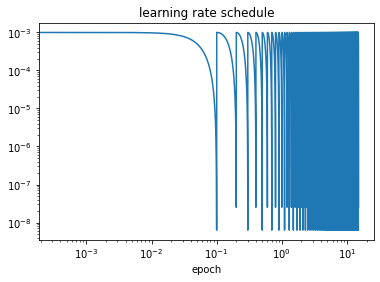

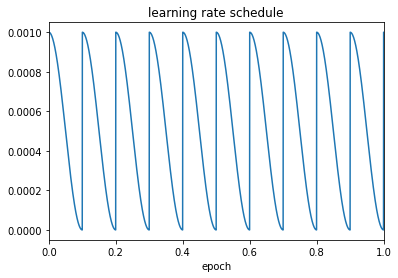

In [75]:
epochs = 15
#batch_size = 1024
# batch_size = 512
# batch_size = 128
batch_size = 32
# batch_size = 16

theta_input_shape = train_thetas.shape[1]
print(f"theta_input_shape: {theta_input_shape}")

print("making traing dataset")

X_train = train_thetas
y_train = train_hps






total_number_of_points = X_train.shape[0]



print(f"total_number_of_points (training): {total_number_of_points}")

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/10,
    # t_mul=2.0,
    t_mul=1.,
    m_mul=1.,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 1)
plt.show()
plt.close()



In [76]:
%%time
theta_b_scale=1
validation_data=(val_thetas, val_hps)
# validation_data=([val_thetas[:,0],val_thetas[:,1],val_thetas[:,2],val_thetas[:,3],val_thetas[:,4],val_thetas[:,5],val_thetas[:,6],val_thetas[:,7],val_thetas[:,8]], val_hps)
history_rff, model_rff = run_model_ds(
    X_train,
    y_train,
    batch_size,
    theta_b_scale,
    theta_input_shape,
    # model_type='rff-all',
    model_type='rff',
    epochs=epochs,
    threshold=1e-7,
    validation_data=validation_data,
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=12,
    units=256,
    activation='relu',
    checkpoint_filepath=None,
)

Epoch 1/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.2961e-05 - val_loss: 1.0573e-04
Epoch 2/15
3125/3125 [==============================] - 23s 7ms/step - loss: 7.8366e-05 - val_loss: 9.3965e-05
Epoch 3/15
3125/3125 [==============================] - 22s 7ms/step - loss: 7.2957e-05 - val_loss: 8.3916e-05
Epoch 4/15
3125/3125 [==============================] - 23s 7ms/step - loss: 6.6911e-05 - val_loss: 8.3528e-05
Epoch 5/15
3125/3125 [==============================] - 22s 7ms/step - loss: 6.4136e-05 - val_loss: 8.8863e-05
Epoch 6/15
3125/3125 [==============================] - 22s 7ms/step - loss: 6.2358e-05 - val_loss: 7.0556e-05
Epoch 7/15
3125/3125 [==============================] - 23s 7ms/step - loss: 5.8015e-05 - val_loss: 7.1335e-05
Epoch 8/15
3125/3125 [==============================] - 23s 7ms/step - loss: 5.6258e-05 - val_loss: 6.0645e-05
Epoch 9/15
3125/3125 [==============================] - 22s 7ms/step - loss: 5.2479e-05 - val_loss: 6.9116e-05
E

In [77]:
model_rff.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 theta_input (InputLayer)    [(None, 9)]               0         
                                                                 
 dense_234 (Dense)           (None, 128)               1280      
                                                                 
 lambda_78 (Lambda)          (None, 128)               0         
                                                                 
 dense_235 (Dense)           (None, 256)               33024     
                                                                 
 dense_236 (Dense)           (None, 256)               65792     
                                                                 
 dense_237 (Dense)           (None, 256)               65792     
                                                                 
 dense_238 (Dense)           (None, 256)               657

In [78]:
%%time
validation_data=(val_thetas, val_hps)
history_plain, model_plains = run_model_ds(
    X_train,
    y_train,
    batch_size,
    theta_b_scale,
    theta_input_shape,
    model_type='plain',
    epochs=epochs,
    threshold=1e-7,
    validation_data=validation_data,
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=12,
    units=256,
    activation='relu',
    checkpoint_filepath=None,
)

Epoch 1/15
3125/3125 [==============================] - 24s 7ms/step - loss: 1.0108e-04 - val_loss: 1.3691e-04
Epoch 2/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.6594e-05 - val_loss: 1.3637e-04
Epoch 3/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.5747e-05 - val_loss: 1.3665e-04
Epoch 4/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.5277e-05 - val_loss: 1.3507e-04
Epoch 5/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.5031e-05 - val_loss: 1.3539e-04
Epoch 6/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.4685e-05 - val_loss: 1.3476e-04
Epoch 7/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.4934e-05 - val_loss: 1.3521e-04
Epoch 8/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.4479e-05 - val_loss: 1.3527e-04
Epoch 9/15
3125/3125 [==============================] - 23s 7ms/step - loss: 9.4259e-05 - val_loss: 1.3491e-04
E

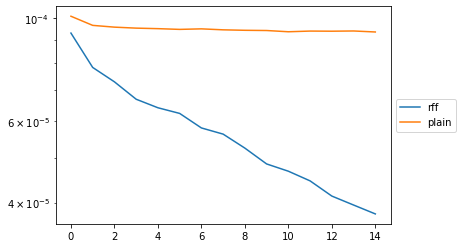

In [79]:
plt.figure()
plt.plot(history_rff.history['loss'], label='rff')
plt.plot(history_plain.history['loss'], label='plain')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

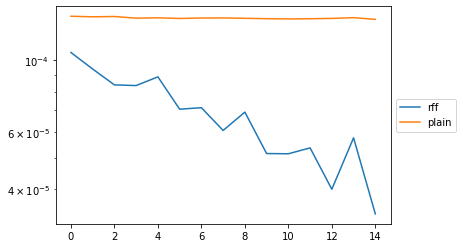

In [80]:
plt.figure()
plt.plot(history_rff.history['val_loss'], label='rff')
plt.plot(history_plain.history['val_loss'], label='plain')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))